# Magma Keras to TensorRT

### Importing

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras.models import Sequential,load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
from tensorflow.python.platform import gfile


import time 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import os
from os.path import isfile, exists, isdir, join

import shutil

Using TensorFlow backend.


### For Jetson TX2

In [2]:
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

tf.keras.backend.set_learning_phase(0)

In [3]:
CNN_MODEL = 'MagmaCnnClassifier.hdf5'
TARGET_SHAPE = 8
DATA_SHAPE = (100,100,3)
OPTIMIZER = Adam()
BATCH_SIZE = 256
EPOCH = 2

SAVED_MODEL_DIR = './saved_model/'
MODEL_NAME = CNN_MODEL

DATA_SHAPE = (100,100,3)
TRAIN_DIR = "./data/train"
TEST_DIR = "./data/test"
RESULT_PREDICTION_CALLBACK = None

# Data preprocessing
### create predict_dir by move random pictures from test_dir  
#### remove and copy test_dir

In [4]:
TEST_COPY_DIR = './data/test_dir'
PREDICT_DIR = './data/predict_dir'

In [6]:
# delete folder if exist
if exists(TEST_COPY_DIR) and isdir(TEST_COPY_DIR):
    shutil.rmtree(TEST_COPY_DIR)
print('remove if exist test_dir success')

if exists(PREDICT_DIR) and isdir(PREDICT_DIR):
    shutil.rmtree(PREDICT_DIR)
print('remove if exist predict_dir success')

#copy test as test_dir, there are result as list of copy files
# from distutils.dir_util import copy_tree
# copy_tree('./data/test','./data/test_dir')
from subprocess import call
call(['cp','-a', TEST_DIR, TEST_COPY_DIR])
print('copy test to test_dir success')

remove if exist test_dir success
remove if exist predict_dir success
copy test to test_dir success


#### create predict_dir and random moving images

In [5]:
#random select images
CATEGORIES = ['0','1','2','3','4','5','6','7']
IMAGES_PER_FOLDER = 1

In [10]:
import random
for category in CATEGORIES:
    
    path_ct = join(TEST_COPY_DIR,category)
    path_pd = join(PREDICT_DIR, category)
    
    if not exists(path_pd):
        os.makedirs(path_pd)
    
    image_list = os.listdir(path_ct)
    random.shuffle(image_list)
    
    for img in image_list[:IMAGES_PER_FOLDER]:
        path_src = join(path_ct,img)
        path_des = join(path_pd,img)
        shutil.move(path_src, path_des)
    
    print('copy - category:',category, image_list[:IMAGES_PER_FOLDER])
    
    

copy - category: 0 ['1202.png']
copy - category: 1 ['5573.png']
copy - category: 2 ['3077.png']
copy - category: 3 ['8448.png']
copy - category: 4 ['8580.png']
copy - category: 5 ['1786.png']
copy - category: 6 ['767.png']
copy - category: 7 ['157.png']


# WorkFlow

### Keras to TensorRT
![alt text](pictures/Keras_to_TensorRT.png)

## d) Inference using TensorRT model

#### d.1) Function to read ".pb" model (TensorRT model is stored in ".pb")

In [6]:
# (can be used to read frozen model or TensorRT model)
def read_pb_graph(model):
    with gfile.FastGFile(model,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

#### prepare data for prediction

In [7]:
images = []
for category in CATEGORIES:
    path_pd = join(PREDICT_DIR, category)
    class_num = CATEGORIES.index(category)
    image_list = os.listdir(path_pd)
    
    for img in image_list:
        images.append([join(path_pd,img),class_num,img])

print(images)
print(images[0][0])


[['./data/predict_dir/0/1202.png', 0, '1202.png'], ['./data/predict_dir/1/5573.png', 1, '5573.png'], ['./data/predict_dir/2/3077.png', 2, '3077.png'], ['./data/predict_dir/3/8448.png', 3, '8448.png'], ['./data/predict_dir/4/8580.png', 4, '8580.png'], ['./data/predict_dir/5/1786.png', 5, '1786.png'], ['./data/predict_dir/6/767.png', 6, '767.png'], ['./data/predict_dir/7/157.png', 7, '157.png']]
./data/predict_dir/0/1202.png


In [8]:
input_img = []

x = 2

for i in range(x):
    
    img = load_img(path=images[i][0], color_mode='rgb', target_size=DATA_SHAPE)
    img2predict = img.copy()
    img2predict = img_to_array(img2predict)
    img2predict /= 255
    input_img.append(img2predict)
#     break # <<-- use only 1 image
    
input_img = np.array(input_img)
print(input_img.shape)

(2, 100, 100, 3)


#### d.2) Perform inference using TensorRT model

In [9]:
# variable
# print(tr_filename)
# TENSORRT_MODEL_PATH = './saved_model/'+tr_filename

TENSORRT_MODEL_PATH = './saved_model/TensorRT_Magma_model_01-07-2019_16-54-31.pb'

# INPUT_TENSOR = INPUTS + ':0'
# OUTPUT_TENSOR = OUTPUTS + ':0'

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.50))) as sess:
        # read TensorRT model
        print('read TensorRT model')
        trt_graph = read_pb_graph(TENSORRT_MODEL_PATH)

        # obtain the corresponding input-output tensor
        print('obtain the corresponding input-output tensor')
        tf.import_graph_def(trt_graph, name='')
        tensor_input = sess.graph.get_tensor_by_name('input_tensor_input:0')
        tensor_output = sess.graph.get_tensor_by_name('output_tensor/Softmax:0')
        
        # write to tensorboard (check tensorboard for each op names)
        writer = tf.summary.FileWriter(SAVED_MODEL_DIR+'forzen_log/')
        writer.add_graph(sess.graph)
        writer.flush()
        writer.close()

        # in this case, it demonstrates to perform inference for 50 times
        print('in this case, it demonstrates to perform inference for 50 times')
        total_time = 0; n_time_inference = 50
        print('before Sess run')
        out_pred = sess.run(tensor_output, feed_dict={tensor_input: input_img}) # <--------- boom here
        print('after Sess run')
        for i in range(n_time_inference):
            t1 = time.time()
            out_pred = sess.run( tensor_output, feed_dict={tensor_input: input_img})
            t2 = time.time()
            delta_time = t2 - t1
            total_time += delta_time
            print("needed time in inference-" + str(i) + ": ", delta_time)
        avg_time_tensorRT = total_time / n_time_inference
        print("average inference time: ", avg_time_tensorRT)

read TensorRT model
obtain the corresponding input-output tensor
in this case, it demonstrates to perform inference for 50 times
before Sess run
after Sess run
needed time in inference-0:  0.016066551208496094
needed time in inference-1:  0.019194602966308594
needed time in inference-2:  0.01940608024597168
needed time in inference-3:  0.02031731605529785
needed time in inference-4:  0.02158331871032715
needed time in inference-5:  0.0221560001373291
needed time in inference-6:  0.020982980728149414
needed time in inference-7:  0.02182769775390625
needed time in inference-8:  0.022562742233276367
needed time in inference-9:  0.0247042179107666
needed time in inference-10:  0.019618749618530273
needed time in inference-11:  0.017512083053588867
needed time in inference-12:  0.023143529891967773
needed time in inference-13:  0.030434370040893555
needed time in inference-14:  0.028888940811157227
needed time in inference-15:  0.01202082633972168
needed time in inference-16:  0.00694704055

#### d.3) Perform inference using the original tensorflow model

In [32]:
# variable
FROZEN_MODEL_PATH = './saved_model/Magma_frozen_model_01-07-2019_16-53-56.pb'

graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:
        # read TensorRT model
        frozen_graph = read_pb_graph(FROZEN_MODEL_PATH)
        
           # print all operation names 
        print('\n===== ouptut operation names =====\n')
        for op in sess.graph.get_operations():
            print(op.name)

        # obtain the corresponding input-output tensor
        tf.import_graph_def(frozen_graph, name='')
        input = sess.graph.get_tensor_by_name('input_tensor_input:0')
        output = sess.graph.get_tensor_by_name('output_tensor/Softmax:0')

        # in this case, it demonstrates to perform inference for 50 times
        total_time = 0; n_time_inference = 50
        out_pred = sess.run(output, feed_dict={input: input_img})
        for i in range(n_time_inference):
            t1 = time.time()
            out_pred = sess.run(output, feed_dict={input: input_img})
            t2 = time.time()
            delta_time = t2 - t1
            total_time += delta_time
            print("needed time in inference-" + str(i) + ": ", delta_time)
        avg_time_original_model = total_time / n_time_inference
        print("average inference time: ", avg_time_original_model)
        print("TensorRT improvement compared to the original model:", avg_time_original_model/avg_time_tensorRT)


===== ouptut operation names =====

needed time in inference-0:  0.010280132293701172
needed time in inference-1:  0.007669687271118164
needed time in inference-2:  0.007061481475830078
needed time in inference-3:  0.0070569515228271484
needed time in inference-4:  0.008172273635864258
needed time in inference-5:  0.00923919677734375
needed time in inference-6:  0.010852575302124023
needed time in inference-7:  0.009143829345703125
needed time in inference-8:  0.010569334030151367
needed time in inference-9:  0.01271820068359375
needed time in inference-10:  0.01394510269165039
needed time in inference-11:  0.013981342315673828
needed time in inference-12:  0.014429092407226562
needed time in inference-13:  0.017218589782714844
needed time in inference-14:  0.018733978271484375
needed time in inference-15:  0.019956350326538086
needed time in inference-16:  0.017821311950683594
needed time in inference-17:  0.020099639892578125
needed time in inference-18:  0.03317523002624512
needed 

#### d.4) Plot the prediction result

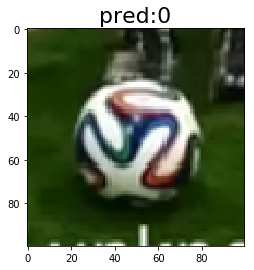

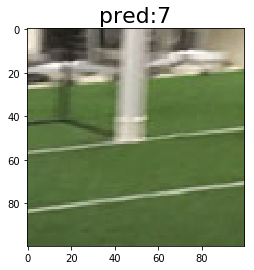

In [40]:
for i in range(len(out_pred)):
    plt.figure('img{}'.format(i))
    img = load_img(path=images[i][0], color_mode='rgb', target_size=DATA_SHAPE)
    plt.imshow(img, cmap=None)
    plt.title('pred:' + str(np.argmax(out_pred[i])), fontsize=22)

# Visualize the original and optimized graphs
Using [netron](https://lutzroeder.github.io/netron/), the web application for vitsulaize model graph by upload .pb file.

## 2. Calulate Time, mAP, ACC of Keras model

## 3. Process in TensorRT

## 4. Calculate Time, mAP, ACC of converted model